## Learning from Scratch

In [1]:
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/gpu:0'

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# dimensions of our images.
img_width, img_height = 150, 150

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

### Creating the Model

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# the model so far outputs 3D feature maps (width, height, features)

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# the final layer is a fully-connected layers with a single unit and a sigmoid activation, 
# which is perfect for a binary classification. 
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [8]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [9]:
# To go with 1 unit FC layer we will also use the binary_crossentropy loss to train our model.
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Let's prepare our data. We will use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

### Preparing the Dataset

In [10]:
nb_train_samples = 1000
nb_validation_samples = 800

epochs = 50
batch_size = 16

In [11]:
# this is the augmentation configuration we will use for training:
train_datagen = ImageDataGenerator(
    rescale=1./ 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [12]:
# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1./ 255)

In [13]:
train_data_dir = 'data/cats-vs-dogs/sample/train'
validation_data_dir = 'data/cats-vs-dogs/sample/valid'

# this is a generator that will read pictures found in
# subfolers of 'data/cats-vs-dogs/sample/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    train_data_dir, # this is the target directory
    target_size=(img_width, img_height), # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode='binary') # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


We can now use these generators to train our model. 

### Training the Model

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size).history

Epoch 1/50
62/62 [==============================] - 11s - loss: 0.7172 - acc: 0.5131 - val_loss: 0.6708 - val_acc: 0.5813
Epoch 2/50
62/62 [==============================] - 9s - loss: 0.6809 - acc: 0.5837 - val_loss: 0.6621 - val_acc: 0.6038
Epoch 3/50
62/62 [==============================] - 9s - loss: 0.6582 - acc: 0.5958 - val_loss: 0.7392 - val_acc: 0.5175
Epoch 4/50
62/62 [==============================] - 10s - loss: 0.6383 - acc: 0.6482 - val_loss: 0.6461 - val_acc: 0.6450
Epoch 5/50
62/62 [==============================] - 10s - loss: 0.6155 - acc: 0.6714 - val_loss: 0.5963 - val_acc: 0.6750
Epoch 6/50
62/62 [==============================] - 10s - loss: 0.6165 - acc: 0.6653 - val_loss: 0.6794 - val_acc: 0.6075
Epoch 7/50
62/62 [==============================] - 11s - loss: 0.6112 - acc: 0.6512 - val_loss: 0.5966 - val_acc: 0.6687
Epoch 8/50
62/62 [==============================] - 11s - loss: 0.5972 - acc: 0.6855 - val_loss: 0.6019 - val_acc: 0.6700
Epoch 9/50
62/62 [========

This approach gets us to a validation accuracy of 0.79-0.81 after 50 epochs (a number that was picked arbitrarily --because the model is small and uses aggressive dropout, it does not seem to be overfitting too much by that point).

In [15]:
model.save_weights('model_weights/learning_from_scratch.h5')

**Plotting Train vs Validation Loss:**

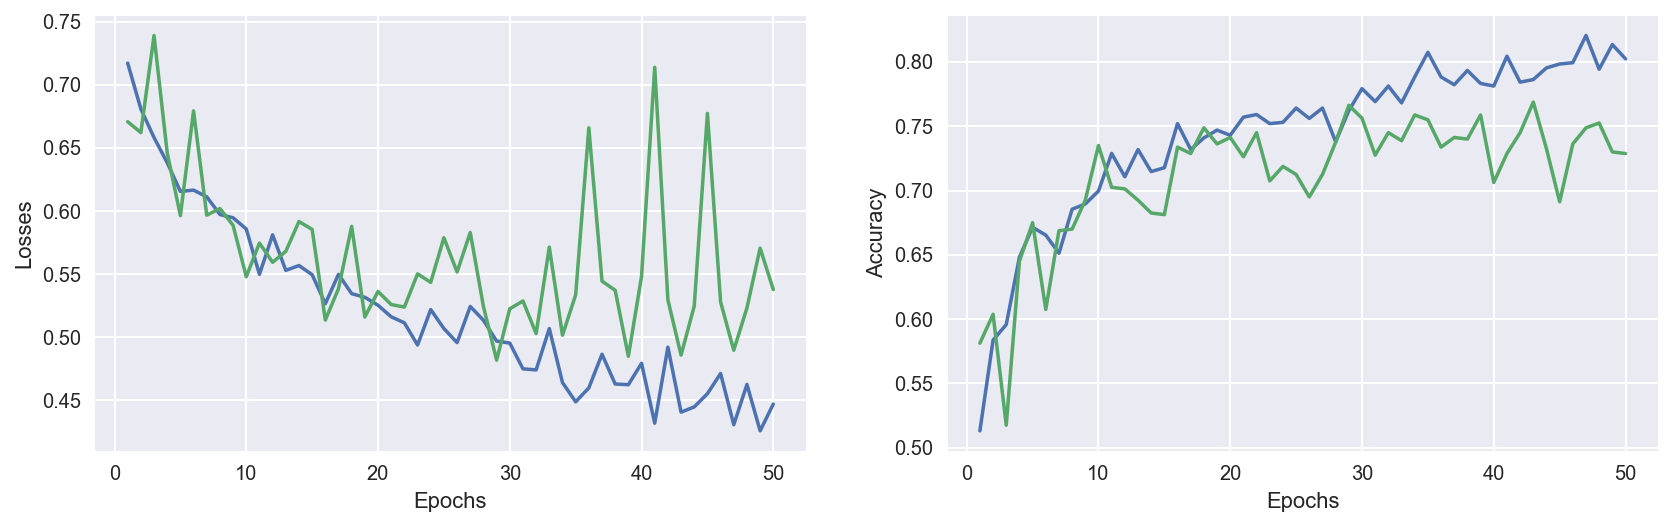

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax[0].plot(range(1, epochs + 1), history['loss'])
ax[0].plot(range(1, epochs + 1), history['val_loss'])
_ = ax[0].set(xlabel='Epochs', ylabel='Losses')
ax[1].plot(range(1, epochs + 1), history['acc'])
ax[1].plot(range(1, epochs + 1), history['val_acc'])
_ = ax[1].set(xlabel='Epochs', ylabel='Accuracy')

## Using the bottleneck features of a pre-trained network: 90% accuracy in a minute

In [17]:
import numpy as np
import pandas as pd

# Visuahttp://localhost:8888/notebooks/ml-workspace/keras-transfer-learning/keras-transfer-learning-Copy1.ipynb#lization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [18]:
import tensorflow as tf
tf.test.gpu_device_name()

'/gpu:0'

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [20]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Input

from keras import applications

from keras.optimizers import SGD, rmsprop

from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

In [21]:
# dimensions of our images.
img_width, img_height = 150, 150

In [22]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [23]:
train_data_dir = 'data/cats-vs-dogs/sample/train'
validation_data_dir = 'data/cats-vs-dogs/sample/valid'

In [24]:
nb_train_samples = 2000
nb_validation_samples = 800

epochs = 50
batch_size = 16

### save the bottleneck features

In [25]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [26]:
# build the VGG16 network
base_model = applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [27]:
train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, # this means our generator will only yield batches of data, no labels
        shuffle=False) # our data will be in order, so all first 1000 images will be cats, then 1000 dogs

Found 2000 images belonging to 2 classes.


In [28]:
# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = base_model.predict_generator(train_generator, nb_train_samples // batch_size)

In [29]:
# Save the bottleneck features
# save the output as a Numpy array
np.save(open('model_features/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [30]:
valid_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None, # this means our generator will only yield batches of data, no labels
        shuffle=False) # our data will be in order, so all first 1000 images will be cats, then 1000 dogs

Found 800 images belonging to 2 classes.


In [31]:
bottleneck_features_validation = base_model.predict_generator(valid_generator, nb_validation_samples // batch_size)  

In [32]:
np.save(open('model_features/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

### train the top model

In [33]:
train_data = np.load(open('model_features/bottleneck_features_train.npy', 'rb'))
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * int((nb_train_samples / 2)) + [1] * int((nb_train_samples / 2)))

validation_data = np.load(open('model_features/bottleneck_features_validation.npy', 'rb'))
validation_labels = np.array([0] * int((nb_validation_samples / 2)) + [1] * int((nb_validation_samples / 2)))

In [34]:
img_input = Input(shape=train_data.shape[1:])
top_network = Flatten(name='top_flatten_1')(img_input)
top_network = Dense(256, activation='relu', name='top_dense_1')(top_network)
top_network = Dropout(0.5, name='top_dropout_1')(top_network)
top_network = Dense(1, activation='sigmoid', name='top_dense_2')(top_network)

In [35]:
top_model = Model(inputs = img_input, outputs = top_network)

In [36]:
print(top_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4, 4, 512)         0         
_________________________________________________________________
top_flatten_1 (Flatten)      (None, 8192)              0         
_________________________________________________________________
top_dense_1 (Dense)          (None, 256)               2097408   
_________________________________________________________________
top_dropout_1 (Dropout)      (None, 256)               0         
_________________________________________________________________
top_dense_2 (Dense)          (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
top_model.compile(optimizer=rmsprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])   

In [38]:
history_bottleneck = top_model.fit(train_data, 
          train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels)).history

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 1s - loss: 0.7922 - acc: 0.7605 - val_loss: 0.2775 - val_acc: 0.8825
Epoch 2/50
2000/2000 [==============================] - 1s - loss: 0.4082 - acc: 0.8395 - val_loss: 0.2769 - val_acc: 0.9012
Epoch 3/50
2000/2000 [==============================] - 1s - loss: 0.3066 - acc: 0.8800 - val_loss: 0.2639 - val_acc: 0.9038
Epoch 4/50
2000/2000 [==============================] - 1s - loss: 0.2672 - acc: 0.9100 - val_loss: 0.2748 - val_acc: 0.9075
Epoch 5/50
2000/2000 [==============================] - 1s - loss: 0.2332 - acc: 0.9120 - val_loss: 0.2678 - val_acc: 0.9050
Epoch 6/50
2000/2000 [==============================] - 1s - loss: 0.2218 - acc: 0.9135 - val_loss: 0.2897 - val_acc: 0.9062
Epoch 7/50
2000/2000 [==============================] - 1s - loss: 0.1897 - acc: 0.9280 - val_loss: 0.3140 - val_acc: 0.9000
Epoch 8/50
2000/2000 [==============================] - 1s - loss: 0.1743 - ac

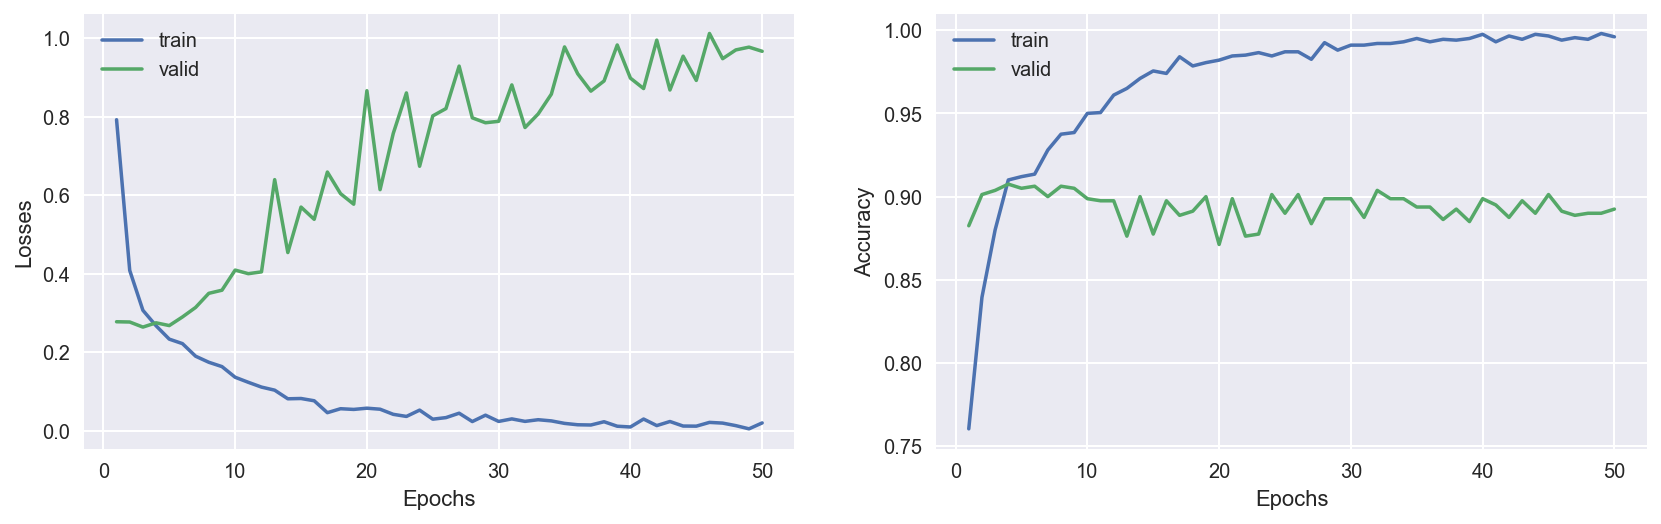

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax[0].plot(range(1, epochs + 1), history_bottleneck['loss'], label='train')
ax[0].plot(range(1, epochs + 1), history_bottleneck['val_loss'], label='valid')
_ = ax[0].set(xlabel='Epochs', ylabel='Losses')
_ = ax[0].legend(loc='best')
ax[1].plot(range(1, epochs + 1), history_bottleneck['acc'], label='train')
ax[1].plot(range(1, epochs + 1), history_bottleneck['val_acc'], label='valid')
_ = ax[1].set(xlabel='Epochs', ylabel='Accuracy')
_ = ax[1].legend(loc='best')

In [40]:
top_model.save_weights('model_weights/bottleneck_fc_model.h5')

## Fine-tuning the top layers of a a pre-trained network

In [41]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Input

from keras import applications

from keras.optimizers import SGD, rmsprop

from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator

In [42]:
# dimensions of our images.
img_width, img_height = 150, 150

In [43]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [44]:
train_data_dir = 'data/cats-vs-dogs/sample/train'
validation_data_dir = 'data/cats-vs-dogs/sample/valid'

In [45]:
nb_train_samples = 2000
nb_validation_samples = 800

epochs = 50
batch_size = 16

In [46]:
top_model_weights_path = 'model_weights/bottleneck_fc_model.h5'

In [47]:
# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [48]:
train_data.shape[1:], base_model.output_shape[1:]

((4, 4, 512), (4, 4, 512))

In [49]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:], name='top_flatten_1'))
top_model.add(Dense(256, activation='relu', name='top_dense_1'))
top_model.add(Dropout(0.5, name='top_dropout_1'))
top_model.add(Dense(1, activation='sigmoid', name='top_dense_2'))

In [50]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights('model_weights/bottleneck_fc_model.h5')

In [51]:
# add the model on top of the convolutional base
fine_tune_model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [52]:
# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in fine_tune_model.layers[:15]:
    layer.trainable = False

In [53]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
fine_tune_model.compile(loss='binary_crossentropy', 
                        optimizer=SGD(lr=1e-4, momentum=0.9), 
                        metrics=['accuracy'])

In [54]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [55]:
print(fine_tune_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [56]:
# fine-tune the model
history_trf_learn = fine_tune_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2).history

Epoch 1/50
48s - loss: 0.7054 - acc: 0.8100 - val_loss: 0.3729 - val_acc: 0.8500
Epoch 2/50
48s - loss: 0.2586 - acc: 0.9040 - val_loss: 0.3116 - val_acc: 0.9038
Epoch 3/50
48s - loss: 0.1832 - acc: 0.9270 - val_loss: 0.2590 - val_acc: 0.9275
Epoch 4/50
48s - loss: 0.1615 - acc: 0.9435 - val_loss: 0.2793 - val_acc: 0.9187
Epoch 5/50
48s - loss: 0.1262 - acc: 0.9545 - val_loss: 0.2419 - val_acc: 0.9287
Epoch 6/50
48s - loss: 0.1161 - acc: 0.9590 - val_loss: 0.2827 - val_acc: 0.9275
Epoch 7/50
48s - loss: 0.1156 - acc: 0.9590 - val_loss: 0.2369 - val_acc: 0.9275
Epoch 8/50
48s - loss: 0.0974 - acc: 0.9670 - val_loss: 0.3362 - val_acc: 0.9113
Epoch 9/50
48s - loss: 0.0824 - acc: 0.9725 - val_loss: 0.3638 - val_acc: 0.9313
Epoch 10/50
48s - loss: 0.0703 - acc: 0.9740 - val_loss: 0.2512 - val_acc: 0.9137
Epoch 11/50
48s - loss: 0.0695 - acc: 0.9735 - val_loss: 0.2926 - val_acc: 0.9287
Epoch 12/50
48s - loss: 0.0667 - acc: 0.9730 - val_loss: 0.2737 - val_acc: 0.9337
Epoch 13/50
48s - loss: 0

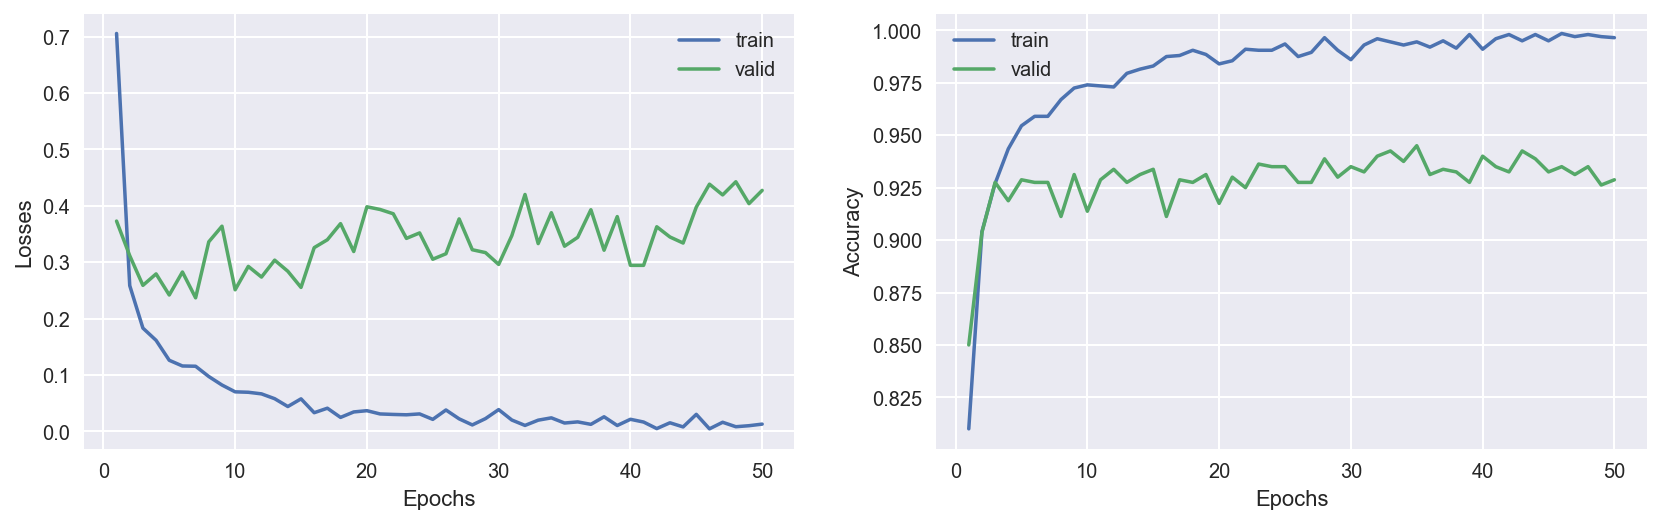

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
ax[0].plot(range(1, epochs + 1), history_trf_learn['loss'], label='train')
ax[0].plot(range(1, epochs + 1), history_trf_learn['val_loss'], label='valid')
_ = ax[0].set(xlabel='Epochs', ylabel='Losses')
_ = ax[0].legend(loc='best')
ax[1].plot(range(1, epochs + 1), history_trf_learn['acc'], label='train')
ax[1].plot(range(1, epochs + 1), history_trf_learn['val_acc'], label='valid')
_ = ax[1].set(xlabel='Epochs', ylabel='Accuracy')
_ = ax[1].legend(loc='best')